In [1]:
import os
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')  

In [2]:
data = pd.read_csv('../input/language-translation-englishfrench/eng_-french.csv')

In [3]:
data.head()

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [4]:
data.isna().sum()

English words/sentences    0
French words/sentences     0
dtype: int64

In [5]:
data.drop_duplicates('English words/sentences',keep='first',inplace = True)

In [6]:
data.describe()

,English words/sentences,French words/sentences
count,123100,123100
unique,123100,116543
top,Hi.,C'est bizarre.
freq,1,9


In [7]:
data.head()

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
3,Who?,Qui ?
4,Wow!,Ça alors !
5,Fire!,Au feu !


In [8]:
english_sen =data['English words/sentences'].values
english_sen

array(['Hi.', 'Run!', 'Who?', ...,
       "Death is something that we're often discouraged to talk about or even think about, but I've realized that preparing for death is one of the most empowering things you can do. Thinking about death clarifies your life.",
       'Since there are usually multiple websites on any given topic, I usually just click the back button when I arrive on any webpage that has pop-up advertising. I just go to the next page found by Google and hope for something less irritating.',
       "If someone who doesn't know your background says that you sound like a native speaker, it means they probably noticed something about your speaking that made them realize you weren't a native speaker. In other words, you don't really sound like a native speaker."],
      dtype=object)

In [9]:
french_sen = data['French words/sentences'].values
french_sen

array(['Salut!', 'Cours\u202f!', 'Qui ?', ...,
       "La mort est une chose qu'on nous décourage souvent de discuter ou même de penser mais j'ai pris conscience que se préparer à la mort est l'une des choses que nous puissions faire qui nous investit le plus de responsabilité. Réfléchir à la mort clarifie notre vie.",
       "Puisqu'il y a de multiples sites web sur chaque sujet, je clique d'habitude sur le bouton retour arrière lorsque j'atterris sur n'importe quelle page qui contient des publicités surgissantes. Je me rends juste sur la prochaine page proposée par Google et espère tomber sur quelque chose de moins irritant.",
       "Si quelqu'un qui ne connaît pas vos antécédents dit que vous parlez comme un locuteur natif, cela veut dire qu'il a probablement remarqué quelque chose à propos de votre élocution qui lui a fait prendre conscience que vous n'êtes pas un locuteur natif. En d'autres termes, vous ne parlez pas vraiment comme un locuteur natif."],
      dtype=object)

In [24]:
import re
def clean_corpus(corpus):
    clean_corpus = []
    for i in range(len(corpus)):
        text = corpus[i].lower()
    
        text = re.sub('[.0-9«»()!$?%!&,+–‽/:;\…₂‘’"\u200bº—€\xadœ]',' ',text)
        text = text.split()
        clean_corpus.append(' '.join(text))
    return clean_corpus

In [25]:
frn_corpus = clean_corpus(french_sen)
frn_corpus[:10]

['salut',
 'cours',
 'qui',
 'ça alors',
 'au feu',
 "à l'aide",
 'saute',
 'ça suffit',
 'attends',
 'poursuis']

In [26]:
eng_corpus = clean_corpus(english_sen)
eng_corpus[:10]

['hi', 'run', 'who', 'wow', 'fire', 'help', 'jump', 'stop', 'wait', 'go on']

In [29]:
french_corpus = []
for i in range(len(frn_corpus)):
    text = 'Start ' + frn_corpus[i] + ' Stop'
    french_corpus.append(text) 

french_corpus[:10]

['Start salut Stop',
 'Start cours Stop',
 'Start qui Stop',
 'Start ça alors Stop',
 'Start au feu Stop',
 "Start à l'aide Stop",
 'Start saute Stop',
 'Start ça suffit Stop',
 'Start attends Stop',
 'Start poursuis Stop']

In [30]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

eng_tk = Tokenizer()
eng_tk.fit_on_texts(eng_corpus)
eng_vocab_size = len(eng_tk.word_index) + 1

frn_tk = Tokenizer()
frn_tk.fit_on_texts(french_corpus)
frn_vocab_size = len(frn_tk.word_index) + 1

In [31]:
eng_vocab_size,frn_vocab_size

(14293, 24265)

In [32]:
max_eng_length = max([len(sent.split()) for sent in eng_corpus])
max_frn_length = max([len(sent.split()) for sent in french_corpus])

In [33]:
max_eng_length,max_frn_length

(44, 57)

In [42]:
split = int(0.9*len(eng_corpus))
eng_train = eng_corpus[:split]
frn_train = french_corpus[:split]
eng_test = eng_corpus[split:]
frn_test = french_corpus[split:]

In [44]:
len(eng_train),len(frn_train),len(eng_test),len(frn_test)

(110790, 110790, 12310, 12310)

In [35]:
from tensorflow.keras.utils import to_categorical

def data_generator(eng_tk, max_eng_length,eng_corpus, frn_tk, frn_vocab_size, max_frn_length,french_corpus, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for i in range(len(french_corpus)):
            n += 1
            eng_seq = eng_tk.texts_to_sequences([eng_corpus[i]])
            features = pad_sequences(eng_seq,padding='post',maxlen=max_eng_length)[0]
            frn_seq = frn_tk.texts_to_sequences([french_corpus[i]])[0]
            for i in range(1, len(frn_seq)):
                in_seq, out_seq = frn_seq[:i], frn_seq[i]
                in_seq = pad_sequences([in_seq],padding='post', maxlen=max_frn_length)[0]
                out_seq = to_categorical([out_seq], num_classes=frn_vocab_size)[0]
                
                X1.append(features)
                X2.append(in_seq)
                y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [53]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input,Embedding,Dense,Dropout,LSTM,add,Bidirectional
from tensorflow.keras.models import Model

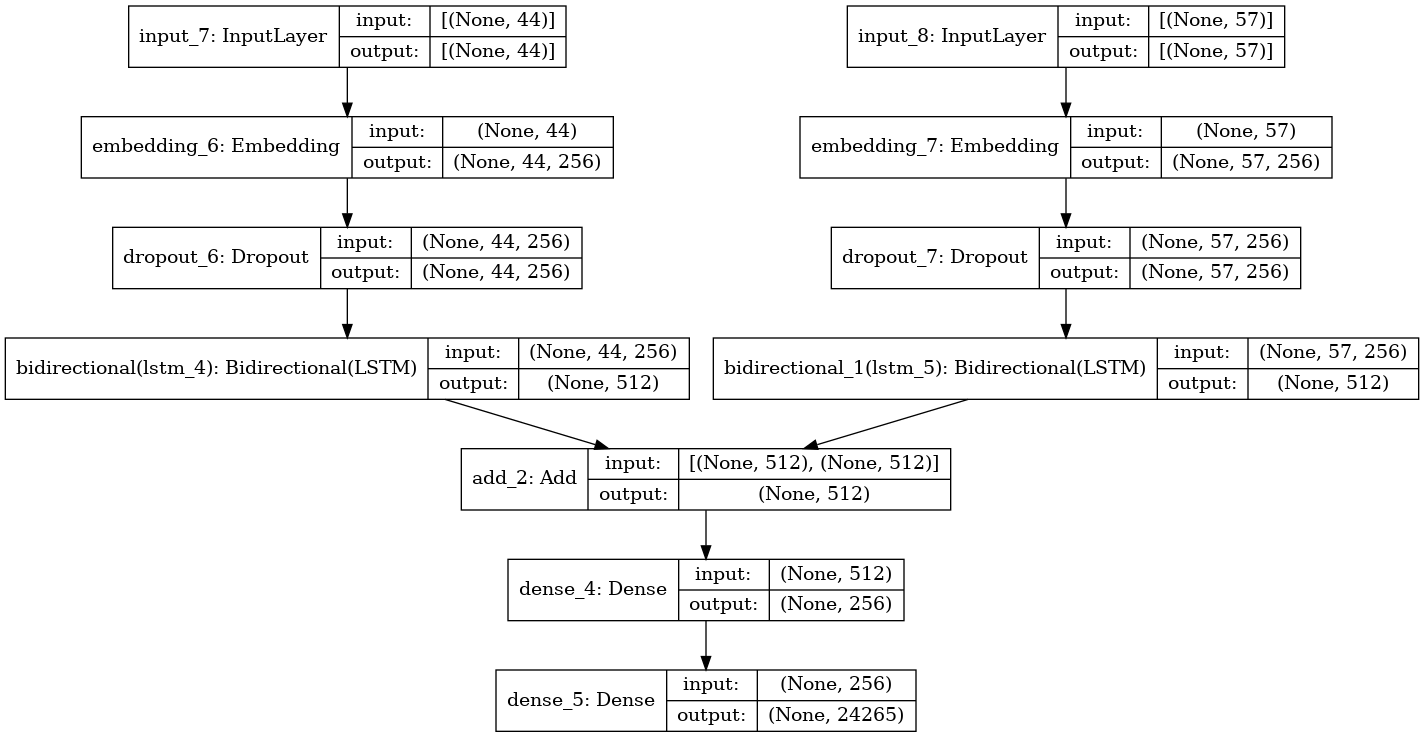

In [56]:
inputs_1 = Input(shape = (max_eng_length,))
encoder_1 = Embedding(eng_vocab_size,256,mask_zero = True)(inputs_1)
encoder_2 = Dropout(0.2)(encoder_1)
encoder_3 = Bidirectional(LSTM(256))(encoder_2)

inputs_2 = Input(shape=(max_frn_length,))
seq_enc1 = Embedding(frn_vocab_size,256,mask_zero = True)(inputs_2)
seq_enc2 = Dropout(0.4)(seq_enc1)
seq_enc3 = Bidirectional(LSTM(256))(seq_enc2)

decoder = add([encoder_3,seq_enc3])
decoder1 = Dense(256,activation='relu')(decoder)
outputs = Dense(frn_vocab_size,activation = 'softmax')(decoder1)

model = Model(inputs = [inputs_1,inputs_2],outputs = outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

In [63]:
epochs = 20
batch_size = 32
steps = len(frn_train) // batch_size

generator = data_generator(eng_tk, max_eng_length,eng_train, frn_tk, frn_vocab_size, max_frn_length,frn_train, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/20
3462/3462 [==============================] - 176s 51ms/step - loss: 0.3735
Epoch 2/20
3462/3462 [==============================] - 177s 51ms/step - loss: 0.3632
Epoch 3/20
3462/3462 [==============================] - 173s 50ms/step - loss: 0.3536
Epoch 4/20
3462/3462 [==============================] - 173s 50ms/step - loss: 0.3473
Epoch 5/20
3462/3462 [==============================] - 172s 50ms/step - loss: 0.3388
Epoch 6/20
3462/3462 [==============================] - 171s 49ms/step - loss: 0.3313
Epoch 7/20
3462/3462 [==============================] - 171s 49ms/step - loss: 0.3263
Epoch 8/20
3462/3462 [==============================] - 169s 49ms/step - loss: 0.3220
Epoch 9/20
3462/3462 [==============================] - 168s 49ms/step - loss: 0.3156
Epoch 10/20
3462/3462 [==============================] - 172s 50ms/step - loss: 0.3096
Epoch 11/20
3462/3462 [==============================] - 171s 49ms/step - loss: 0.3052
Epoch 12/20
3462/3462 [=============================

In [58]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [59]:
def translator(sentence):

    text = 'Start'
    eng_seq = eng_tk.texts_to_sequences([sentence])
    features = pad_sequences(eng_seq,padding='post',maxlen=max_eng_length)[0]
    for i in range(max_frn_length):
        sequence = frn_tk.texts_to_sequences([text])[0]
        sequence = pad_sequences([sequence],padding = 'post',maxlen=max_frn_length)[0]
        prediction = model.predict([features.reshape(1,44),sequence.reshape(1,57)])
        prediction = np.argmax(prediction)
        word = idx_to_word(prediction,frn_tk)
        if word is None:
            break
        text += ' '+ word
        if word=='stop':
            break
    return text

In [97]:
translator('hello')

'Start bonjour stop'

In [109]:
translator('last night')

'Start la nuit dernière est passée la nuit dernière stop'

In [111]:
translator('thank you')

'Start merci à vous stop'

In [113]:
translator('very tired')

'Start bien très fatigué stop'

In [116]:
translator('english to french')

"Start apprendre l'anglais a eu parler français stop"

In [100]:
from tqdm.notebook import tqdm
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()

for i in tqdm(range(len(frn_test))):
    text = eng_test[i]
    translation = translator(text) 
    actual_translation = frn_test[i].split()
    
    translation = translation.split()
   
    actual.append(actual_translation)
    predicted.append(translation)
    
print(corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))

  0%|          | 0/12310 [00:00<?, ?it/s]

0.02297558474342287
